In [1]:
import h5py

# Get times of GRBs
grbfile = h5py.File('./grbevents.hdf', 'r')
grbtimes = grbfile['times'][:]

days = (grbtimes.max() - grbtimes.min()) / 86400.0
npday =  len(grbtimes) / days
swait = 86400 / npday
print days, swait

155.5827963511563 11324.644991356281


In [2]:
import numpy
from pycbc.conversions import mchirp_from_mass1_mass2
from pycbc.cosmology import redshift

# Shift the source distribution to the detector frame by using the threashold 
# redshift
z = redshift(140)
print "redshift shift", z

# Get times of coinc GWs
gwdat = h5py.File('./bns.hdf')['triggers'][:]

# Error is 
# (good references in https://arxiv.org/pdf/1806.05097.pdf)
# https://arxiv.org/pdf/1603.02698.pdf
#1.33 +- .09 # error should dominate over GW measurement
std = .09
mid = 1.33
sig = 2

min_mchirp = mchirp_from_mass1_mass2(mid-sig*std, mid-sig*std) * (1 + z)
max_mchirp = mchirp_from_mass1_mass2(mid+sig*std, mid+sig*std) * (1 + z)

mc = mchirp_from_mass1_mass2(gwdat['mass1'], gwdat['mass2'])
l = (mc > min_mchirp) & (mc < max_mchirp)
gwnum = l.sum()

gwidx = numpy.where(l)[0]
gwtimes = 0.5 * (gwdat['H1_end_time'][:] + gwdat['L1_end_time'][:])
gwtimes = gwtimes[gwidx]

print min_mchirp, max_mchirp

redshift shift 0.0309081946172
1.03207636596 1.35516114139


In [3]:
# Size of window to get ~ 1 event per coincident anlaysis time 
expnum = 1
window = expnum * swait / float(gwnum) / 2.0
print window
window = 1.7

1.6678416776666098


In [4]:
offset = 1.7 # offset for GW170817 median

def coincs(gw, grb):
    gw = gw.copy()
    grb = grb.copy() - offset
    sort = grb.argsort()
    grb = grb[sort]
    left = numpy.searchsorted(grb, gw - window)
    right = numpy.searchsorted(grb, gw + window)

    gwfound = numpy.where((right - left) > 0)[0]
    grbfound = left[gwfound]
    return gwfound, sort[grbfound]

tslide = numpy.arange(-5000, -5) * window
tslide2 = numpy.arange(5, 5000) * window
tslide = numpy.concatenate([tslide, tslide2])

In [5]:
import healpy as hp
from astropy.time import Time
NSIDE = 32

def pix2radec(index):
    theta, phi=hp.pixelfunc.pix2ang(NSIDE, index)
    return numpy.pi*2. - phi, numpy.pi/2 - theta

def radec2pix(ra, dec):
    return hp.pixelfunc.ang2pix(NSIDE, numpy.pi/2-dec, numpy.pi*2 - ra)

gwmaps = h5py.File('./gmaps.hdf', 'r')
amaps = h5py.File('./amaps.hdf', 'r')
hlmap = amaps['H1L1'][:]
hmap = amaps['H1'][:]
lmap = amaps['L1'][:]

reftime = amaps.attrs['TIME']
anamaps = {'H1L1':hlmap, 'H1':hmap, 'L1':lmap}

def anamap(time, ifo):
    refmap = anamaps[ifo]
    tref =  Time(reftime, format='gps', location=(0, 0), 
                 scale='utc').sidereal_time('mean').rad

    trad = Time(time, format='gps', location=(0, 0), 
                 scale='utc').sidereal_time('mean').rad
    dra = (trad - tref) % (numpy.pi * 2.0)

    idx = numpy.arange(0, len(refmap))
    ra, dec = pix2radec(idx)
    nidx = radec2pix((ra + dra) % (numpy.pi * 2), dec)

    m = numpy.zeros(len(refmap))
    m[nidx] = refmap[idx]
    return m

def getbstat(t, s, t1, t2, ifo):
    midx = gwidx[t1]
    grbm = grbfile['map'][str(t2)][:]
    
    try:
        gwm = gwmaps[str(midx)][:]
    except:
        gwm = anamap(t, ifo)
        
    B = (grbm*gwm).sum()*len(gwm)
    if B < .0001:
        return 6.5
    
    s2 = (s**2.0 + 2.0 * numpy.log(B))**0.5
    return s2

bkg = {}
fg = {}

In [6]:
# Calculate the background
bi1 = []
bi2 = []
for slide in tslide:
    i1, i2 = coincs(gwtimes, grbtimes + slide)
    bi1.append(i1)
    bi2.append(i2)
bi1 = numpy.concatenate(bi1)
bi2 = numpy.concatenate(bi2)
print len(bi1)

bstat = gwdat['stat'][:][gwidx][bi1]
btimes = gwtimes[bi1]

bstat2 = []
for t, s, t1, t2 in zip(btimes, bstat, bi1, bi2):
    s2 = getbstat(t, s, t1, t2, 'H1L1')
    bstat2.append(s2)
    
bkg['H1L1'] = bstat2

10383


In [7]:
fi1, fi2 = coincs(gwtimes, grbtimes)
fstat = gwdat['stat'][gwidx][fi1]
ftimes = gwtimes[fi1]

fstat2 = []
for s, t1, t2 in zip(fstat, fi1, fi2):
    s2 = getbstat(ftimes, s, t1, t2, 'H1L1')
    fstat2.append(s2)
    
fg['H1L1'] = (fstat, ftimes)

In [8]:
sfile = h5py.File('./singles.hdf', 'r')

for ifo in ['H1', 'L1']:
    stimes = sfile[ifo]['time'][:]
    stat = sfile[ifo]['stat'][:]    
    
    # Apply chirp cut
    mc = mchirp_from_mass1_mass2(sfile[ifo]['mass1'][:], sfile[ifo]['mass2'][:])
    lgwidx = (mc < max_mchirp) & (mc > min_mchirp)
    lgwidx = numpy.where(lgwidx)[0]
    print len(mc), len(lgwidx)
    
    stimes = stimes[lgwidx]
    stat = stat[lgwidx]
    
    # Find the coincs
    bi1 = []
    bi2 = []
    for slide in tslide:
        i1, i2 = coincs(stimes, grbtimes + slide)
        bi1.append(i1)
        bi2.append(i2)
    bi1 = numpy.concatenate(bi1)
    bi2 = numpy.concatenate(bi2)
    
    # calculate the statistic
    bstat2 = []
    for t, s, t1, t2 in zip(stimes[bi1], stat[bi1], bi1, bi2):
        s2 = getbstat(t, s, t1, t2, ifo)
        bstat2.append(s2)
    
    bkg[ifo] = bstat2
    
    
    # Calculate the foreground
    fi1, fi2 = coincs(stimes, grbtimes)
    fstat = stat[fi1]
    ftimes = stimes[fi1]

    fstat2 = []
    for s, t1, t2 in zip(fstat, fi1, fi2):
        s2 = getbstat(ftimes, s, t1, t2, ifo)
        fstat2.append(s2)
    
    fg[ifo] = (fstat2, ftimes)

1127 769
694 498


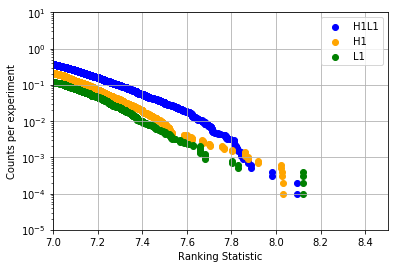

In [13]:
import pylab
colors = {'H1L1':'blue', 'H1':'orange', 'L1':'green'}

for ifo in bkg:
    bstat = numpy.array(bkg[ifo]).copy()
    bstat.sort()
    count = numpy.arange(len(bstat), 0, -1.0) / len(tslide)
    pylab.scatter(bstat, count, label=ifo, c=colors[ifo])
    
    # Coding this part blind...fingers crossed
    # fstat, ftime = fg[ifo]
    # fstat = numpy.array(fstat)
    # ftime = numpy.array(ftime)
    # fstat.sort()
    # fcount = numpy.arange(len(fstat), 0, -1.0)
    # if len(stat) > 0:
    #     pylab.scatter(fstat, fcount, marker='x', c=colors[ifo], label='%s Results' % ifo)
    
pylab.legend()
pylab.yscale('log')
pylab.ylim(1e-5, 10)
pylab.xlim(7, 8.5)
pylab.ylabel('Counts per experiment')
pylab.xlabel('Ranking Statistic')
pylab.grid()
pylab.show()